In [1]:
import pandas as pd
from home_messages_db import HomeMessagesDB

import seaborn as sns
import matplotlib.pyplot as plt


# Busiest rooms
The `smartthings` data contains measurements for motion sensors all throughout the house. 

One thing to analyze is how often certain locations (rooms) inside the house are frequented, and whether the behavior of the residents changes during the year.


### Fetching data from database

**Important**: Make sure that the *entire* smartthings dataset has been *raw-inserted* to your database as such:
`python3 smartthings.py --rawinsert 'sqlite:///db/myhome.db' 'data/smartthings/smartthings.*` (or any other SQLite db of your choosing).


In [2]:
MyDB = HomeMessagesDB('sqlite:///db/myhome.db') 
MyDB # check if the `smartthings_RAW` table has been inserted in your database!

A HomeMessagesDB-class instance. Connected to: sqlite:///db/myhome.db 

TABLES 		COLUMNS

p1e_t1    	['time', 'imported T1', 'exported T1']
p1e_t2    	['time', 'imported T2', 'exported T2']
p1g       	['time', 'Total gas used']
smartthings_RAW	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_attic	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_bathroom	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_floor	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_garden	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_ground	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_kitchen	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']
smartthings_living	['loc', 'level', 'name', 'time', 'capability', 'attribute', 'value', 'unit']

In [3]:
statement = "SELECT name, time, value from smartthings_RAW WHERE attribute='motion'"
motion_data = MyDB.query(stmt=statement, as_df=True, rawSQL=True)
motion_data

,name,time,value
0,kitchen (move),1709381571,active
1,kitchen (stairs),1709381579,active
2,kitchen (stairs),1709381641,inactive
3,kitchen (move),1709381651,inactive
4,kitchen (move),1709420415,active
...,...,...,...
364672,living room (move),1688161699,inactive
364673,living room (move),1688161749,active
364674,bathroom (sensor eye),1688161771,inactive
364675,bathroom (sensor eye),1688162262,active


### Data Cleanup
- Converting unix time back to dates
- Creating `month` column
- Only keeping `active` columns (removing unnecessary `inactive`'s)

In [20]:
busyrooms = motion_data.copy()
busyrooms['time'] = pd.to_datetime(busyrooms['time'], unit='s')
busyrooms['month'] = busyrooms['time'].dt.month
busyrooms = busyrooms[busyrooms['value'] == 'active']
busyrooms.set_index('time', inplace=True)
busyrooms

,name,value,month
time,,,
2024-03-02 12:12:51,kitchen (move),active,3
2024-03-02 12:12:59,kitchen (stairs),active,3
2024-03-02 23:00:15,kitchen (move),active,3
2024-03-02 23:00:21,living room (move),active,3
2024-03-02 23:02:29,kitchen (stairs),active,3
...,...,...,...
2023-06-30 21:45:21,living room (move),active,6
2023-06-30 21:45:32,bathroom (sensor eye),active,6
2023-06-30 21:47:17,living room (move),active,6


In total, 182,121 independent motion signals were recorded from 14-10-2022 to 22-04-2024. It is possible that some similarly-labeled devices will record functionally identical activities (e.g. `kitchen (move)` and `kitchen (stairs)` might be recording the same space inside the house causing their signals to co-occur), however since this can not be verified, all devices will be considered separately.

### Grouping measurements by month
- Separate `active`-counts by `name` (location of sensor) and `month`
- Create new column `relative_activity` which is the number of activity measurements for a specific sensor location as *fraction* of the total amount of measurements *in that month*.

In [31]:
busyrooms_grouped = busyrooms.groupby(['month', 'name']).count()
busyrooms_grouped['totalcount'] = busyrooms_grouped.groupby(['month'])['value'].transform('sum')

busyrooms_grouped['relative_activity'] = busyrooms_grouped['value'] / busyrooms_grouped['totalcount']
busyrooms_grouped

value  totalcount  relative_activity
month name                                                         
1     bathroom (sensor eye)     5654       25557           0.221231
      blue room (move aeotec)   1693       25557           0.066244
      blue room (move cube)      407       25557           0.015925
      garden air (sensor)          1       25557           0.000039
      green room (move cube)     361       25557           0.014125
...                              ...         ...                ...
12    green room (move cube)     159       20024           0.007940
      kitchen (cam)             3360       20024           0.167799
      kitchen (move)            2080       20024           0.103875
      kitchen (stairs)          4292       20024           0.214343
      living room (move)        4755       20024           0.237465

[82 rows x 3 columns]

In [77]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


### Plotting the results

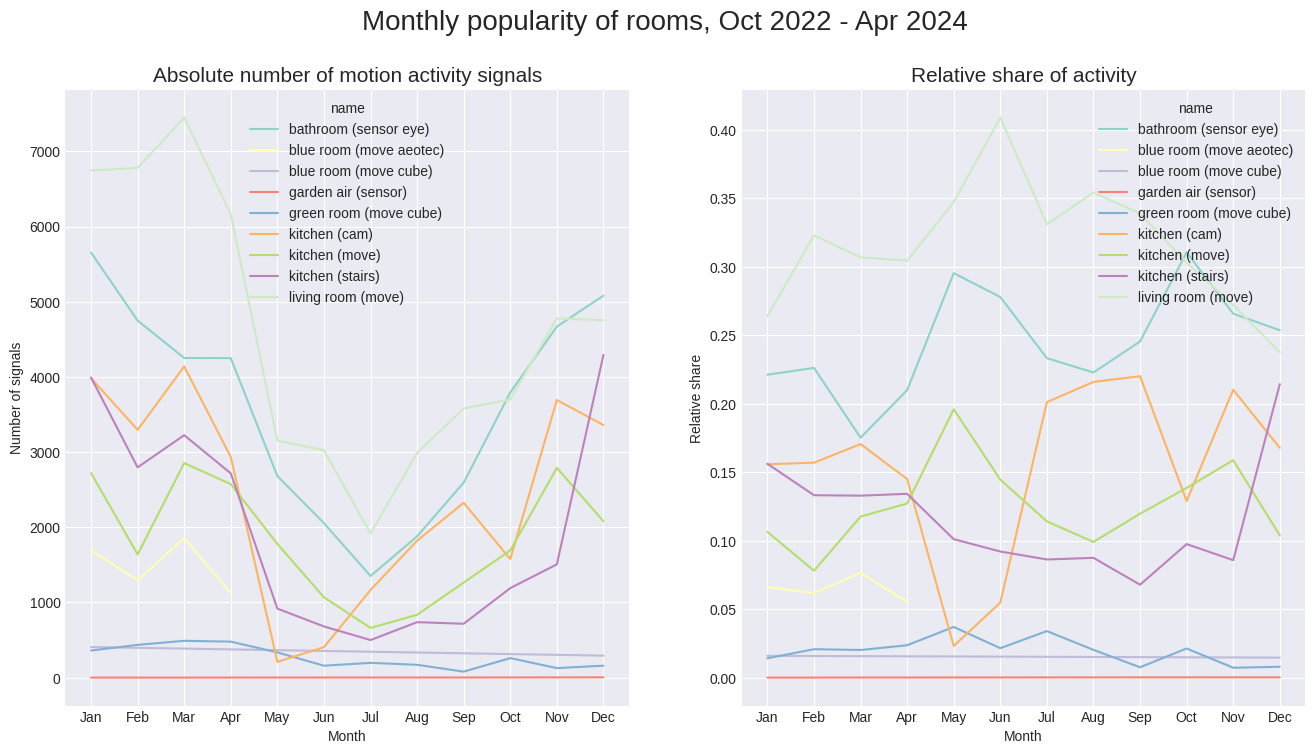

In [108]:
plt.style.use('seaborn-v0_8-darkgrid')


fig, axes = plt.subplots(1,2, figsize=(16,8), sharex=True)
fig.suptitle('Monthly popularity of rooms, Oct 2022 - Apr 2024', fontsize=20)

# Absolute activity
sns.lineplot(ax=axes[0], data=busyrooms_grouped, x="month", y="value", hue="name")
axes[0].set_title('Absolute number of motion activity signals', fontsize=15)
axes[0].set(ylabel='Number of signals', xlabel='Month')

# Relative frequency of activity
sns.lineplot(ax=axes[1], data=busyrooms_grouped, x='month', y='relative_activity', hue='name')
axes[1].set_title('Relative share of activity', fontsize=15)
axes[1].set(ylabel='Relative share', xlabel='Month')


plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

It was observed that the relative popularity of different rooms is not constant throughout the months of the year. Whereas the living room remained the most popular room throughout, getting approx. 25-45% of the total movement signals, it seems to display a peak in relative activity during the summer months. Perhaps this is due to people staying awake for longer and spend more time in the living room in contrast to the kitchen or bathroom, whose occupance could be assumed to be more stable throughout the year. However, when looking at the absolute number of activity signals it can be observed that, in total, the house is less busy during these summer months (i.e. the residents spend more time outside of the house). 

The large discrepancies in total activity in the summer vs. winter months illustrates the value of looking at the *relative* activity shares when analyzing the behavior of the residents. In general it can be observed that the living room is the most popular room, and mostly so during the warm months of the year. The bathroom's activity seems to be mostly stable (approx. 20-30% of the total activity), and comes in 2nd place. The kitchen is the 3rd most popular, although these results are less conclusive due to the possibility of overlapping/co-occuring motion signals registered by multiple `kitchen` devices. The green room comes in 4th.

# Night time?

It is also possible to look at the activity at night (between the hours of 01:00 and 04:00). 

In [107]:
print(f"Total amount of motion signals: {busyrooms.shape[0]}, of which {busyrooms_night.shape[0]} ({round((busyrooms_night.shape[0]/busyrooms.shape[0])*100, 2)}%) were recorded between 01:00 and 04:00.")

Total amount of motion signals: 182121, of which 4448 (2.44%) were recorded between 01:00 and 04:00.


Overall, the nightly motion signals accounted for 2.44% of all signals. Let's take a closer look.

In [98]:
busyrooms_night = busyrooms.between_time('01:00', '03:59') 
busyrooms_night_grouped = busyrooms_night.groupby(['month', 'name']).count()
busyrooms_night_grouped['totalcount'] = busyrooms_night_grouped.groupby(['month'])['value'].transform('sum')

busyrooms_night_grouped['relative_activity'] = busyrooms_night_grouped['value'] / busyrooms_night_grouped['totalcount']

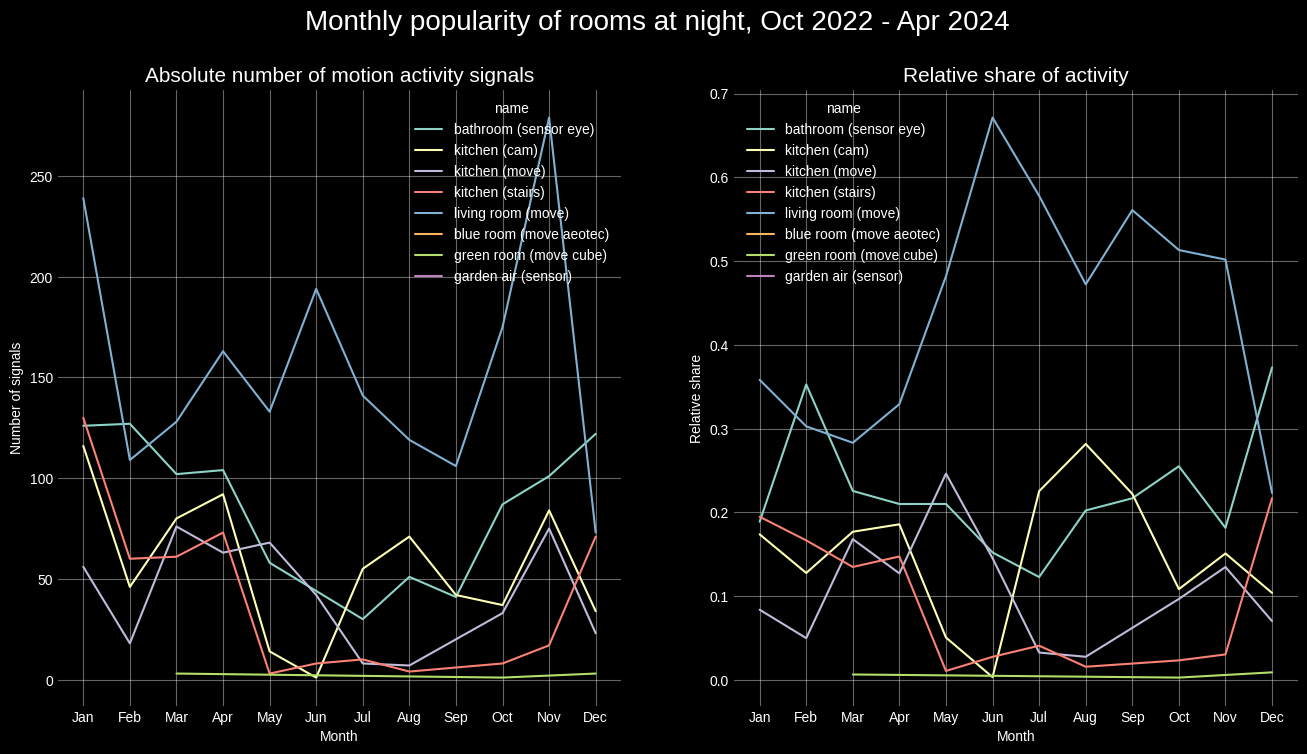

In [96]:
plt.style.use('dark_background')


fig, axes = plt.subplots(1,2, figsize=(16, 8), sharex=True)
fig.suptitle('Monthly popularity of rooms at night, Oct 2022 - Apr 2024', fontsize=20)

# Absolute activity
sns.lineplot(ax=axes[0], data=busyrooms_night_grouped, x="month", y="value", hue="name")
axes[0].set_title('Absolute number of motion activity signals', fontsize=15)
axes[0].set(ylabel='Number of signals', xlabel='Month')
axes[0].grid(which='both', alpha=0.4)

# Relative frequency of activity
sns.lineplot(ax=axes[1], data=busyrooms_night_grouped, x='month', y='relative_activity', hue='name')
axes[1].set_title('Relative share of activity', fontsize=15)
axes[1].set(ylabel='Relative share', xlabel='Month')
axes[1].grid(which='both', alpha=0.4)


plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

When only looking at activity at night, the living room is still the most popular room. However, its popularity has only intensified, even reaching ~ 65% of total activity at its peak in June. This can probably be mostly explained by a decrease in kitchen and bathroom activity. Still, it is somewhat surprising that there seems to be steady activity at night all throughout the year. Possible explanations could be 1. false positive signals by motion sensors, 2. nightowl(s) among the home residents, 3. cats, or 4. ghosts. 